### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np
import tpot as tp
import imblearn
from collections import Counter
from tpot import TPOTClassifier
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, ClusterCentroids 
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
sns.set()

### Load data into pandas dataframe

In [2]:
bc_data = pd.read_csv('breast-cancer-wisconsin.data',names=['id_number','Clump Thickness', 'Uniformity of Cell Size',
                 'Uniformity of Cell Shape', 'Marginal Adhesion', 
                 'Single Epithelial Cell Size','Bare Nuclei',
                 'Bland Chromatin','Normal Nucleoli','Mitosis','Class'])
bc_data.head()

,id_number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitosis,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [10]:
bc2 = pd.read_csv('bc_data.csv', header = [1])

In [12]:
bc2.columns

Index(['id_number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitosis', 'Class', 'id_number.1', 'Diagnosis',
       'radius', 'mean_radius', 'texture', 'mean_texture', 'perimeter',
       'mean_perimeter', 'area', 'mean_area', 'smoothness', 'mean_smoothness',
       'compactness', 'mean_compactness', 'concavity', 'mean_concavity',
       'concave_points', 'mean_concave_points', 'symmetry', 'mean_symmetry',
       'fractal_dimension', 'mean_fractal_dimension'],
      dtype='object')

### visualize the target class numbers to check for balance of classifier column

Benign: 458
Malignant: 241
Proportion: 1.9 : 1


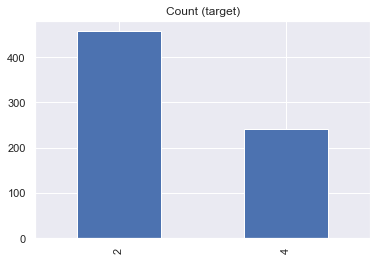

In [14]:
target_count = bc2.Class.value_counts()
print('Benign:', target_count[2])
print('Malignant:', target_count[4])
print('Proportion:', round(target_count[2] / target_count[4], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Check data types in the dataframe

In [15]:
bc2.dtypes

id_number                        int64
Clump Thickness                  int64
Uniformity of Cell Size          int64
Uniformity of Cell Shape         int64
Marginal Adhesion                int64
Single Epithelial Cell Size      int64
Bare Nuclei                     object
Bland Chromatin                  int64
Normal Nucleoli                  int64
Mitosis                          int64
Class                            int64
id_number.1                    float64
Diagnosis                       object
radius                         float64
mean_radius                    float64
texture                        float64
mean_texture                   float64
perimeter                      float64
mean_perimeter                 float64
area                           float64
mean_area                      float64
smoothness                     float64
mean_smoothness                float64
compactness                    float64
mean_compactness               float64
concavity                

create a target array and remove it from the data table

get dummies for bare nuclei

In [17]:

bc_data_with_dummies = pd.get_dummies(bc2)

In [22]:
bc_data_with_dummies.columns

Index(['id_number', 'Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bland Chromatin', 'Normal Nucleoli',
       'Mitosis', 'radius', 'mean_radius', 'texture', 'mean_texture',
       'perimeter', 'mean_perimeter', 'area', 'mean_area', 'smoothness',
       'mean_smoothness', 'compactness', 'mean_compactness', 'concavity',
       'mean_concavity', 'concave_points', 'mean_concave_points', 'symmetry',
       'mean_symmetry', 'fractal_dimension', 'mean_fractal_dimension',
       'Bare Nuclei_1', 'Bare Nuclei_10', 'Bare Nuclei_2', 'Bare Nuclei_3',
       'Bare Nuclei_4', 'Bare Nuclei_5', 'Bare Nuclei_6', 'Bare Nuclei_7',
       'Bare Nuclei_8', 'Bare Nuclei_9', 'Bare Nuclei_?'],
      dtype='object')

In [18]:
target = bc_data_with_dummies['Class']
bc_data_with_dummies.drop('Class', axis = 1, inplace = True)
bc_data_with_dummies.head()

,id_number,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,id_number.1,...,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
0,1000025,5,1,1,1,2,3,1,1,842302.0,...,0,0,0,0,0,0,0,0,0,0
1,1002945,5,4,4,5,7,3,2,1,842517.0,...,1,0,0,0,0,0,0,0,0,0
2,1015425,3,1,1,1,2,3,1,1,84300903.0,...,0,1,0,0,0,0,0,0,0,0
3,1016277,6,8,8,1,3,3,7,1,84348301.0,...,0,0,0,1,0,0,0,0,0,0
4,1017023,4,1,1,3,2,3,1,1,84358402.0,...,0,0,0,0,0,0,0,0,0,0


set index to id number

In [23]:
bc_data_with_dummies.set_index('id_number', inplace = True)

In [24]:
bc_data_with_dummies.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bland Chromatin,Normal Nucleoli,Mitosis,radius,mean_radius,...,Bare Nuclei_10,Bare Nuclei_2,Bare Nuclei_3,Bare Nuclei_4,Bare Nuclei_5,Bare Nuclei_6,Bare Nuclei_7,Bare Nuclei_8,Bare Nuclei_9,Bare Nuclei_?
id_number,,,,,,,,,,,,,,,,,,,,,
1000025,5,1,1,1,2,3,1,1,17.99,10.38,...,0,0,0,0,0,0,0,0,0,0
1002945,5,4,4,5,7,3,2,1,20.57,17.77,...,1,0,0,0,0,0,0,0,0,0
1015425,3,1,1,1,2,3,1,1,19.69,21.25,...,0,1,0,0,0,0,0,0,0,0
1016277,6,8,8,1,3,3,7,1,11.42,20.38,...,0,0,0,1,0,0,0,0,0,0
1017023,4,1,1,3,2,3,1,1,20.29,14.34,...,0,0,0,0,0,0,0,0,0,0


### Split data into training and testing sets

In [25]:
features = bc_data_with_dummies

X = bc_data_with_dummies
y = target

features_train, features_test, target_train, target_test = train_test_split(X, y, test_size=0.30, random_state=1)

### testing data with xgboost to see what the accuracy score is without balancing the data first

In [26]:

model = XGBClassifier()
model.fit(features_train, target_train)
target_pred = model.predict(features_test)

accuracy = accuracy_score(target_test, target_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.57%


confusion matrix

Confusion matrix:
 [[135   2]
 [  1  72]]


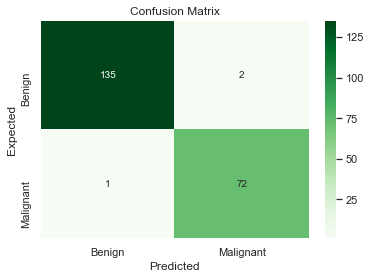

In [27]:
conf_mat = confusion_matrix(y_true=target_test, y_pred=target_pred)
print('Confusion matrix:\n', conf_mat)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g', cmap = 'Greens'); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Expected'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant']);

Function to plot PCA and resampling results

In [28]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

PCA to visualize the classes

In [29]:
pca = PCA(n_components=39)
pca_result = pca.fit_transform(bc_data_with_dummies)

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

plot_2d_space(pca_result, y, 'Imbalanced dataset (39 PCA components)')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

### Testing different resampling methods

Testing SMOTE oversampling method which generates new samples in the smaller sample from its nearest neighbors

[(2, 340), (4, 340)]


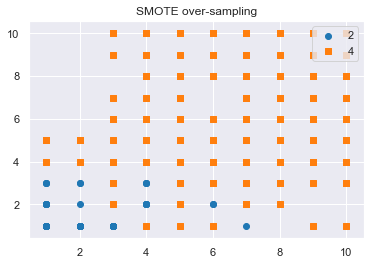

In [11]:
smote = SMOTE(ratio='minority')
X_sm, y_sm = smote.fit_sample(features_train, target_train)
print(sorted(Counter(y_sm).items()))

plot_2d_space(X_sm, y_sm, 'SMOTE over-sampling')

Testing SMOTE and Tomek combination over and undersampling method

[(2, 338), (4, 338)]


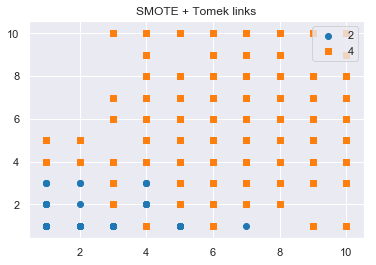

In [12]:
smt = SMOTETomek(ratio='auto')
X_smt, y_smt = smt.fit_sample(features_train, target_train)
print(sorted(Counter(y_smt).items()))

plot_2d_space(X_smt, y_smt, 'SMOTE + Tomek links')

Testing SMOTE + NN combination over and under sampling method

[(2, 316), (4, 306)]


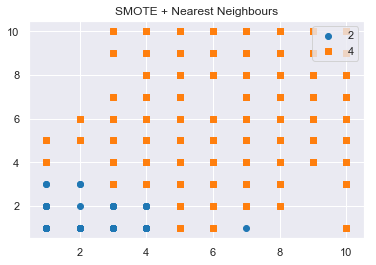

In [13]:
smote_enn = SMOTEENN(random_state=0)
X_smenn, y_smenn = smote_enn.fit_resample(features_train, target_train)
print(sorted(Counter(y_smenn).items()))

plot_2d_space(X_smenn, y_smenn, 'SMOTE + Nearest Neighbours')

 Testing ADASYN Over-sampling

[(2, 340), (4, 327)]


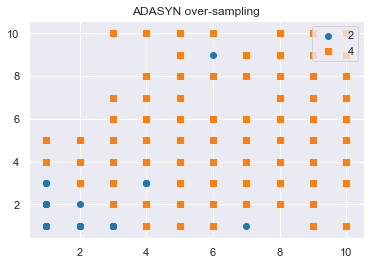

In [14]:
from imblearn.over_sampling import ADASYN 
ada = ADASYN()
X_ada, y_ada = ada.fit_sample(features_train,target_train)
print(sorted(Counter(y_ada).items()))

plot_2d_space(X_ada,y_ada, 'ADASYN over-sampling')

### TPOT

In [34]:
tpot = TPOTClassifier(generations=50, population_size= 50, cv = 10, verbosity= 2, n_jobs= 1)
tpot.fit(X_sm,y_sm)

Generation 1 - Current best internal CV score: 0.9779411764705882
Generation 2 - Current best internal CV score: 0.9779411764705882
Generation 3 - Current best internal CV score: 0.9779411764705882
Generation 4 - Current best internal CV score: 0.9779411764705882
Generation 5 - Current best internal CV score: 0.9779411764705882
Generation 6 - Current best internal CV score: 0.9779411764705882
Generation 7 - Current best internal CV score: 0.9779411764705882
Generation 8 - Current best internal CV score: 0.9779411764705882
Generation 9 - Current best internal CV score: 0.9794117647058824
Generation 10 - Current best internal CV score: 0.9794117647058824
Generation 11 - Current best internal CV score: 0.9794117647058824
Generation 12 - Current best internal CV score: 0.9808823529411764
Generation 13 - Current best internal CV score: 0.9808823529411764
Generation 14 - Current best internal CV score: 0.9808823529411764
Generation 15 - Current best internal CV score: 0.9808823529411764
Gene

TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=10,
               disable_update_check=False, early_stop=None, generations=50,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=50,
               random_state=None, scoring=None, subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [36]:
print(tpot.score(features_test,target_test))

0.9714285714285714


In [37]:
tpot.export('tpot_bc_pipeline_ada.py')

### using the chosen model from tpot

In [15]:
from sklearn.ensemble import ExtraTreesClassifier

In [17]:
extratrees = ExtraTreesClassifier(bootstrap=True, criterion="entropy", max_features=0.6500000000000001, min_samples_leaf=1, min_samples_split=6, n_estimators=100)
extratrees.fit(X_smt,y_smt)

extratrees_pred = extratrees.predict(features_test)

accuracy = accuracy_score(target_test, extratrees_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 97.14%


Confusion matrix:
 [[114   4]
 [  1  56]]


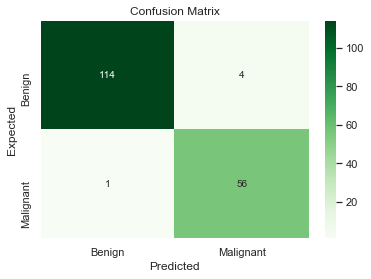

In [18]:
conf_mat = confusion_matrix(y_true=target_test, y_pred=extratrees_pred)
print('Confusion matrix:\n', conf_mat)

ax= plt.subplot()
sns.heatmap(conf_mat, annot=True, ax = ax, fmt = 'g', cmap = 'Greens'); 

# labels, title and ticks
ax.set_xlabel('Predicted');ax.set_ylabel('Expected'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Benign', 'Malignant']); ax.yaxis.set_ticklabels(['Benign', 'Malignant']);

In [19]:
def plot_feature_importances(model):
    n_features = features_train.shape[1]
    plt.figure(figsize=(8,15))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), features_train.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")

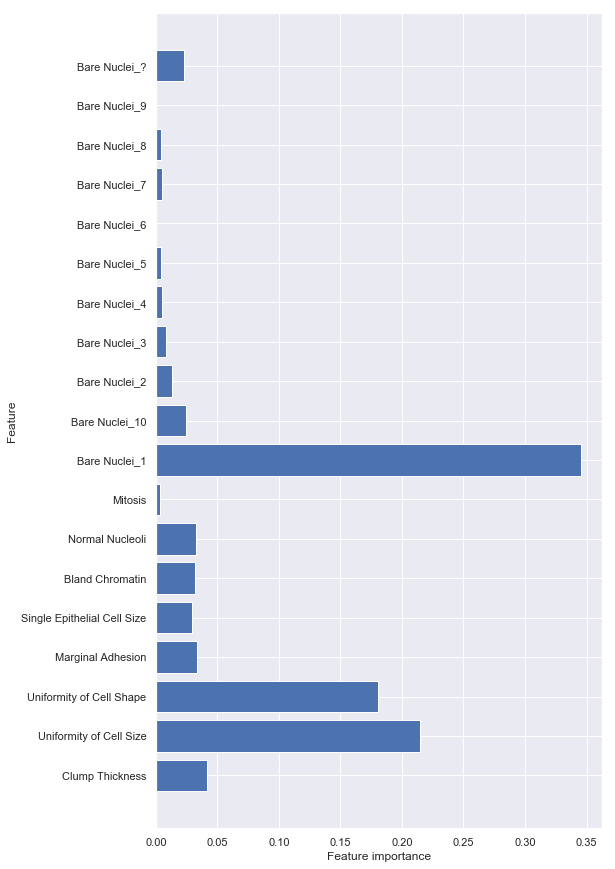

In [20]:
plot_feature_importances(extratrees)

In [21]:
print(classification_report(target_test,extratrees_pred))

              precision    recall  f1-score   support

           2       0.99      0.97      0.98       118
           4       0.93      0.98      0.96        57

    accuracy                           0.97       175
   macro avg       0.96      0.97      0.97       175
weighted avg       0.97      0.97      0.97       175



### visualizing one of the trees 

In [22]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os     
os.environ["PATH"] += os.pathsep + 'Macintosh HD⁩/⁨Users⁩/harrisonmiller⁩/anaconda3⁩/⁨envs⁩/learn-env⁩/lib⁩/⁨python3.6⁩/site-packages⁩'
dot_data = StringIO()
export_graphviz(extratrees.estimators_[0], out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

/Users/harrisonmiller/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


InvocationException: GraphViz's executables not found

### ROC, PRECISION-RECALL GRAPHS

In [21]:
#calculate ROC curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
probs = extratrees.predict_proba(target_test)
probs = probs[:,1]
fpr, tpr, thresholds = roc_curve(target_test,probs)
plt.plot([0,1],[0,1], linestyle='--')
plt.plot(fpr, tpr, marker = '.')
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[2. 2. 2. 4. 2. 2. 4. 2. 2. 2. 4. 4. 2. 4. 4. 4. 2. 2. 2. 2. 2. 4. 4. 2.
 4. 2. 4. 2. 2. 2. 2. 4. 4. 4. 4. 4. 2. 4. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2.
 2. 2. 2. 2. 4. 2. 4. 4. 4. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2.
 2. 2. 4. 4. 2. 2. 2. 2. 4. 4. 2. 4. 2. 2. 2. 4. 4. 2. 4. 2. 2. 2. 2. 4.
 2. 2. 2. 2. 2. 2. 4. 2. 2. 4. 4. 2. 4. 2. 4. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 4. 4. 4. 2. 4. 2. 4. 2. 2. 2. 4. 4. 2. 4. 2. 2. 2. 4. 4. 2. 4. 2. 2.
 2. 4. 2. 4. 2. 2. 2. 2. 2. 4. 2. 2. 2. 2. 2. 2. 2. 4. 2. 2. 4. 4. 2. 2.
 2. 2. 2. 4. 4. 2. 2.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
#calculate Precision-Recall curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
probs = model.predict_proba(testx)
probs = probs[:,2]
yhat = model.predict(testx)
precision, recall, thresholds = precision_recall_curve(testy,probs)
plt.plot([0,1],[0,1], linestyle='--')
pyplot.plot(recall,precision, marker ='.')
pyplot.show()